In [2]:
# I import this so I can make requests to the Stack Exchange API
import requests
# I use this to slow down requests to avoid hitting the API rate limit
import time
# This is the API key I generated for my Stack Exchange developer app
# Using this key allows me to make up to 10,000 requests per day
stack_api_key = 'rl_KEBzf3S9BTFJCsFWoGaPu9EdK'

In [3]:
# I define a function that takes an accepted answer ID and returns the full text of that answer
def get_accepted_answer_body(answer_id):
    import html  # I use this to decode HTML characters inside the answer body

    # I prepare the URL to hit the Stack Exchange Answers API
    url = f"https://api.stackexchange.com/2.3/answers/{answer_id}"

    # I pass the required parameters including my API key and filter to get the answer body
    params = {
        'site': 'stackoverflow',
        'filter': 'withbody',  # I use this filter because it includes the 'body' field
        'key': stack_api_key
    }

    # I make the request to fetch the answer
    response = requests.get(url, params=params)

    # If the request is successful and there's at least one answer returned, I grab the body
    if response.status_code == 200:
        items = response.json().get('items', [])
        if items:
            return html.unescape(items[0].get('body', ''))

    # If something goes wrong or there's no answer, I return an empty string
    return ''

In [4]:
# This function loads any previous data I’ve already saved to a CSV file
# It helps me avoid starting over if my notebook crashes or disconnects
def load_previous_progress(filename):
    import csv
    import os

    if not os.path.exists(filename):
        return []

    with open(filename, mode='r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        return list(reader)

In [5]:
# I define the main function that collects NLP-tagged posts from Stack Overflow
# It fetches their titles, bodies, tags, and accepted answers if available
# It also saves backups every 10 pages so I can continue later if needed
def collect_nlp_posts_with_answers(target_total=20000, backup_filename='stackoverflow_nlp_backup.csv'):
    import csv, os
    # I check if there’s any saved progress and load it if available
    collected_data = load_previous_progress(backup_filename)
    current_page = len(collected_data) // 100 + 1
    print(f"Resuming from page {current_page}. Already collected {len(collected_data)} posts.")

    while len(collected_data) < target_total:
        url = 'https://api.stackexchange.com/2.3/questions'
        params = {'page': current_page, 'pagesize': 100, 'order': 'desc', 'sort': 'creation', 'tagged': 'nlp', 'site': 'stackoverflow', 'filter': 'withbody', 'key': stack_api_key}

        response = requests.get(url, params=params)
        # If something goes wrong with the request, I stop the collection to avoid bad data
        if response.status_code != 200:
            print(f"Request failed on page {current_page} with status {response.status_code}")
            break
        # If the response has no posts, that means I’ve reached the end
        posts = response.json().get('items', [])
        if not posts:
            break

        for post in posts:
            accepted_id = post.get('accepted_answer_id')
            answer_body = get_accepted_answer_body(accepted_id) if accepted_id else ''

            # I store all the fields I need in a single dictionary
            post_entry = {'title': post.get('title'), 'body': post.get('body'), 'tags': ','.join(post.get('tags', [])), 'accepted_answer_id': accepted_id, 'accepted_answer_body': answer_body, 'creation_date': post.get('creation_date'), 'view_count': post.get('view_count'), 'score': post.get('score'), 'link': post.get('link')}
            collected_data.append(post_entry)

        print(f"Finished page {current_page}. Total collected: {len(collected_data)}")
        current_page += 1
        time.sleep(0.5)
         # I save my progress every 10 pages so that if something crashes, I don't lose all my work
        if current_page % 10 == 0:
            with open(backup_filename, mode='w', newline='', encoding='utf-8') as backup_file:
                writer = csv.DictWriter(backup_file, fieldnames=['title', 'body', 'tags', 'accepted_answer_id', 'accepted_answer_body', 'creation_date', 'view_count', 'score', 'link'])
                writer.writeheader()
                writer.writerows(collected_data)
            print(f"Progress saved to {backup_filename}")

    return collected_data

In [68]:
# I define a function that saves all final results into a proper CSV file
def save_final_dataset(post_data, filename):
    import csv
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=['title', 'body', 'tags', 'accepted_answer_id', 'accepted_answer_body', 'creation_date', 'view_count', 'score', 'link'])
        writer.writeheader()
        writer.writerows(post_data)

# I start the whole process from here
if __name__ == '__main__':
    final_post_list = collect_nlp_posts_with_answers(target_total=20000, backup_filename='stackoverflow_nlp_backup.csv')
    # After collection is complete, I save it to a final output CSV
    save_final_dataset(final_post_list, 'stackoverflow_nlp_20k_full_dataset.csv')
    print("All done. Final dataset saved as 'stackoverflow_nlp_20k_full_dataset.csv'")

Resuming from page 1. Already collected 0 posts.
Finished page 1. Total collected: 100
Finished page 2. Total collected: 200
Finished page 3. Total collected: 300
Finished page 4. Total collected: 400
Finished page 5. Total collected: 500
Finished page 6. Total collected: 600
Finished page 7. Total collected: 700
Finished page 8. Total collected: 800
Finished page 9. Total collected: 900
Progress saved to stackoverflow_nlp_backup.csv
Finished page 10. Total collected: 1000
Finished page 11. Total collected: 1100
Finished page 12. Total collected: 1200
Finished page 13. Total collected: 1300
Finished page 14. Total collected: 1400
Finished page 15. Total collected: 1500
Finished page 16. Total collected: 1600
Finished page 17. Total collected: 1700
Finished page 18. Total collected: 1800
Finished page 19. Total collected: 1900
Progress saved to stackoverflow_nlp_backup.csv
Finished page 20. Total collected: 2000
Finished page 21. Total collected: 2100
Finished page 22. Total collected: 

In [7]:
import pandas as pd
# I read the CSV file into a DataFrame called df so I can work with it like a table
df = pd.read_csv("stackoverflow_nlp_20k_full_dataset.csv")

In [8]:
# I show basic structural info about the dataset
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20080 entries, 0 to 20079
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 20080 non-null  object 
 1   body                  20080 non-null  object 
 2   tags                  20080 non-null  object 
 3   accepted_answer_id    8189 non-null   float64
 4   accepted_answer_body  8189 non-null   object 
 5   creation_date         20080 non-null  int64  
 6   view_count            20080 non-null  int64  
 7   score                 20080 non-null  int64  
 8   link                  20080 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 1.4+ MB
None


In [9]:
# I display summary statistics for numerical columns like view_count and score
print("Summary Statistics:")
print(df[['view_count', 'score']].describe())

Summary Statistics:
          view_count         score
count   20080.000000  20080.000000
mean     1923.671514      1.778287
std      8419.394893      6.333648
min         8.000000     -7.000000
25%       160.000000      0.000000
50%       486.000000      1.000000
75%      1356.000000      2.000000
max    473717.000000    287.000000


In [10]:
# I create a new column by joining the title, body, and accepted answer together
# This gives me one block of text for each post that I can clean and analyze
df["full_text"] = (
    df["title"].fillna("") + " " +
    df["body"].fillna("") + " " +
    df["accepted_answer_body"].fillna("")
)

In [11]:
# I convert all the text in the full_text column to lowercase
# This makes sure that the same word with different cases is treated uniformly
df["full_text"] = df["full_text"].str.lower()

In [12]:
# Many posts include HTML tags like <p> or <code>, especially in the body and answer
# I remove these tags so that only clean text is left behind
!pip install lxml
# I use lxml here instead of html.parser because some Stack Overflow posts have broken HTML
from bs4 import BeautifulSoup

def remove_html_tags(text):
    return BeautifulSoup(text, "lxml").get_text()

df["full_text"] = df["full_text"].apply(remove_html_tags)

In [13]:
# I remove stopwords like "the", "is", "in", etc. since they don’t help with understanding the topic
# This helps reduce noise and keeps only the important words

import nltk
nltk.download()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
# Identifier - Punkt_tab
stop_words = set(stopwords.words("english"))
banned_words = {"s", "t", "x", "daae", "ye", "nan", "none"}
def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [
        word for word in tokens
        if word.lower() not in stop_words and word.isalpha() and len(word) > 2 and word.lower() not in banned_words
    ]
    return " ".join(filtered_tokens)


NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> punkt_tab


      Unzipping tokenizers/punkt_tab.zip.



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
# Now I break the cleaned text into individual words
# This allows me to analyze or model the post content as a sequence of tokens

from nltk.tokenize import word_tokenize

def tokenize_text(text):
    return word_tokenize(text)

df["tokens"] = df["full_text"].apply(tokenize_text)

In [15]:
# I create a list of phrases that I want to remove from the full_text column
# These were identified as noise or irrelevant for the WordCloud
unwanted_phrases = [
    "nan", "none none", "file line", "line file", "print print", "word word",
    "thank", "please help", "import import", "def self","ye","def", "return", "print", "self", "get", "value", "name"
]

# I go through each post and remove these unwanted phrases from the text
def remove_noise_phrases(text):
    for phrase in unwanted_phrases:
        text = text.replace(phrase, "")
    return text

# I apply this cleaning step to all posts
df["full_text"] = df["full_text"].apply(remove_noise_phrases)

In [16]:
# I define a function to remove any single characters or symbols that don’t help
# This will clean out things like >, =, x, etc., and keep only meaningful words
def clean_extra_noise(text):
    tokens = text.split()
    filtered = [word for word in tokens if len(word) > 1 and word.isalpha()]
    return " ".join(filtered)

# I apply the noise cleaning to remove short, symbolic, or meaningless tokens
df["full_text"] = df["full_text"].apply(clean_extra_noise)

EDA

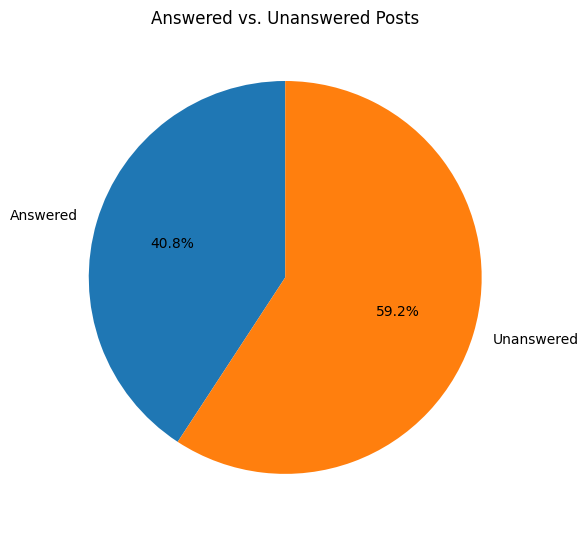

In [17]:
import matplotlib.pyplot as plt
answered = df['accepted_answer_body'].notna() & (df['accepted_answer_body'].str.strip() != '')
answered_count = answered.sum()
unanswered_count = len(df) - answered_count
plt.figure(figsize=(6, 6))
plt.pie([answered_count, unanswered_count], labels=['Answered', 'Unanswered'], autopct='%1.1f%%', startangle=90)
plt.title('Answered vs. Unanswered Posts')
plt.tight_layout()
plt.show()


Answered vs. Unanswered Posts

I made this pie chart to see how many NLP questions on Stack Overflow actually got an accepted answer.  
It shows that more than half of the questions were unanswered, which tells me that a lot of people didn’t get solutions to their problems.  
This helps me understand how active the community is in replying to NLP questions.


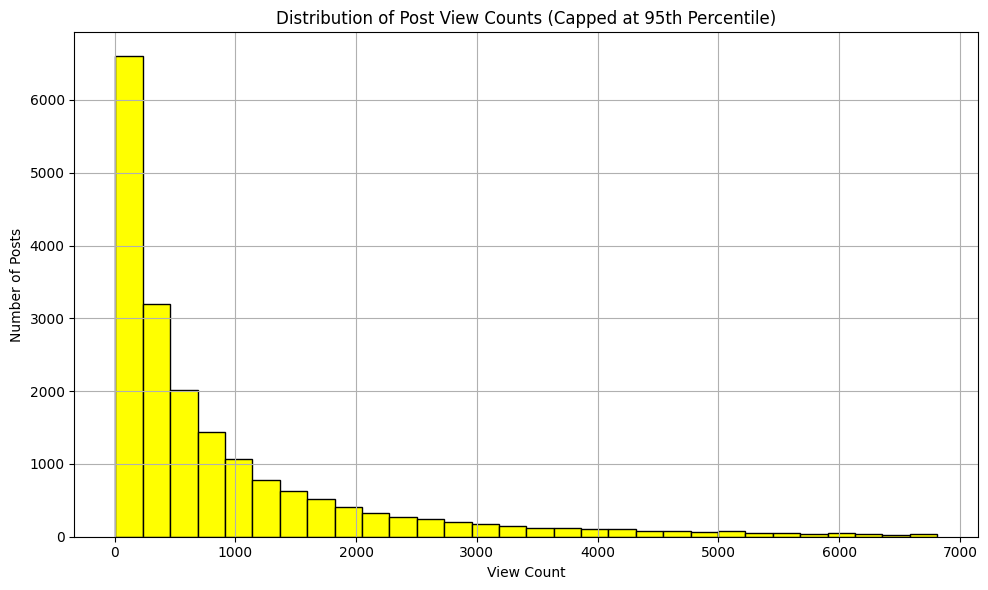

In [18]:
import pandas as pd
# I make sure the 'view_count' is numeric in case it's not
df['view_count'] = pd.to_numeric(df['view_count'], errors='coerce')
# I cap the view count at the 95th percentile to remove outliers
threshold = df['view_count'].quantile(0.95)
filtered_views = df[df['view_count'] <= threshold]['view_count']
# I plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_views, bins=30, edgecolor='black', color='yellow')
plt.title('Distribution of Post View Counts (Capped at 95th Percentile)')
plt.xlabel('View Count')
plt.ylabel('Number of Posts')
plt.grid(True)
plt.tight_layout()
plt.show()

Distribution of Post View Counts (Capped at 95th Percentile)

I made this chart to show how many people viewed the questions. I removed the extreme top 5% of view counts so it’s easier to see the pattern. Most NLP posts on Stack Overflow are seen by fewer than 1,000 people, and only a small number become very popular. This tells me that even in a niche topic like NLP, a few helpful posts get a lot of attention.


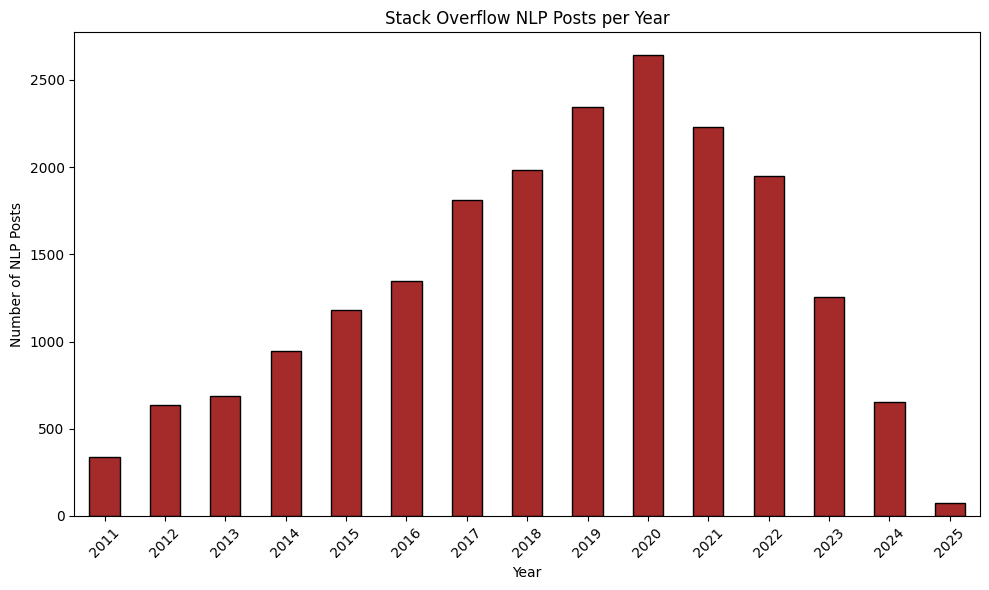

In [19]:
df['creation_date'] = pd.to_datetime(df['creation_date'], unit='s', errors='coerce')
df['year'] = df['creation_date'].dt.year
plt.figure(figsize=(10, 6))
df['year'].value_counts().sort_index().plot(kind='bar', color='brown', edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Number of NLP Posts')
plt.title('Stack Overflow NLP Posts per Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Stack Overflow NLP Posts per Year

I wanted to see how NLP interest changed over the years, so I plotted this bar chart.  
It shows that NLP questions kept increasing until around 2020, and then started to drop a bit.  
This helps me understand when NLP was trending more and when the community was more active.


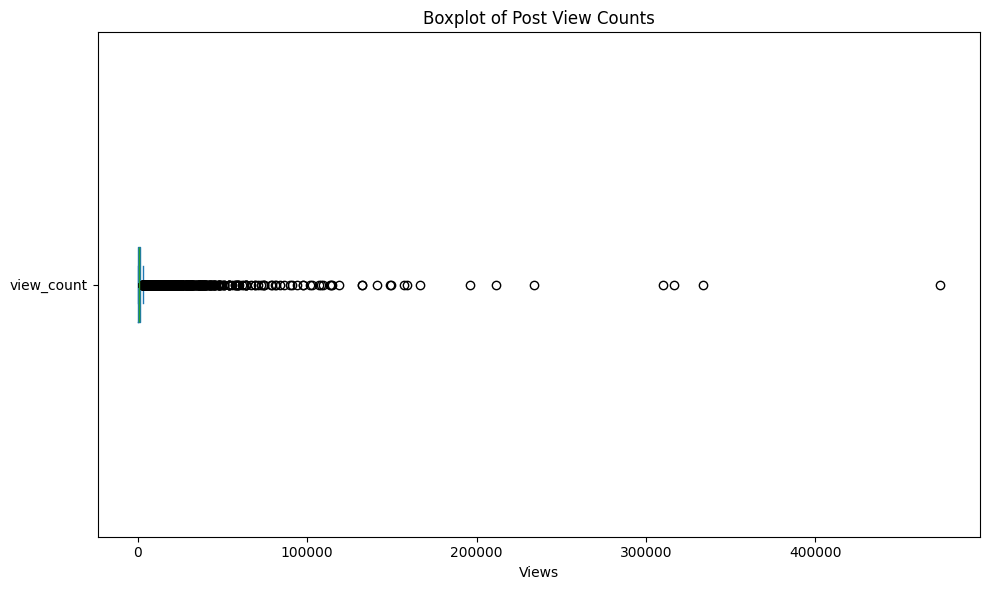

In [20]:
plt.figure(figsize=(10, 6))
df['view_count'].dropna().astype(int).plot.box(vert=False)
plt.title('Boxplot of Post View Counts')
plt.xlabel('Views')
plt.tight_layout()
plt.show()

Boxplot of View Counts

This boxplot shows how view counts are spread out.  
Most questions have very low views, and a few questions have extremely high views, which I see as outliers.  
This helps me understand the popularity differences in the posts and shows that only a few posts get a lot of attention.


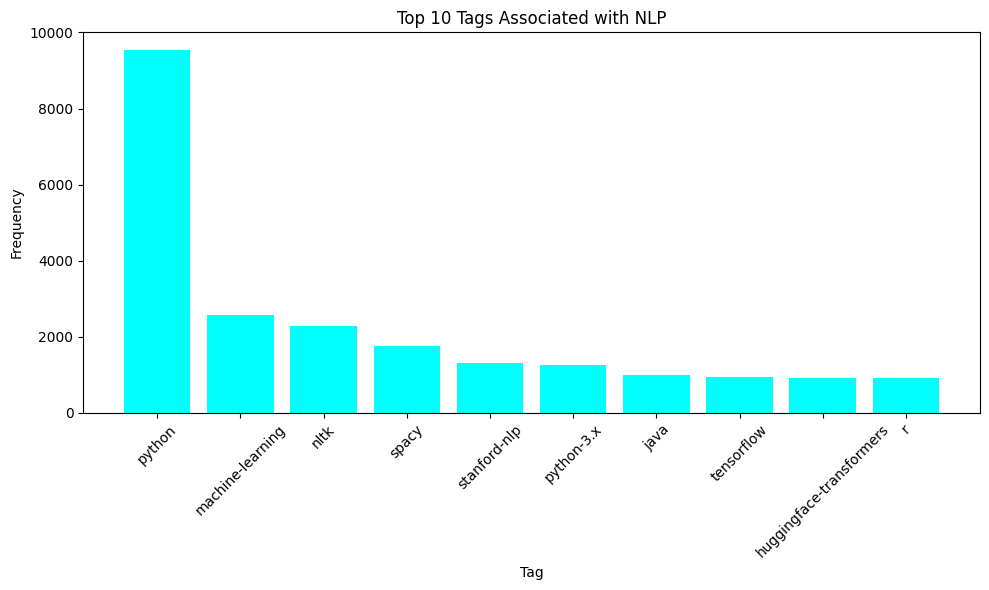

In [21]:
from collections import Counter
# Spliting tags and flattening them into a list
tag_series = df['tags'].dropna().str.split(',').explode()
filtered_tags = tag_series[tag_series != 'nlp']  # Excluding the main tag "NLP"
top_tags = Counter(filtered_tags).most_common(10)
tags, counts = zip(*top_tags)
plt.figure(figsize=(10, 6))
plt.bar(tags, counts, color='cyan')
plt.title('Top 10 Tags Associated with NLP')
plt.xlabel('Tag')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Top 10 Tags Associated with NLP

This chart shows the top 10 tags that were used with “nlp”.  
I see that tags like “python”, “machine-learning”, and “nltk” are very common.  
It tells me that these tools and topics are often discussed when developers work on NLP problems.  
This helps me understand which technologies are popular in the NLP field.


In [22]:
top_posts = df[['title', 'link', 'score']].sort_values(by='score', ascending=False).head(5)
import IPython.display as disp
disp.display(top_posts)

,title,link,score
19714,How to compute the similarity between two text...,https://stackoverflow.com/questions/8897593/ho...,287
11707,googletrans stopped working with error &#39;No...,https://stackoverflow.com/questions/52455774/g...,224
15413,How to determine the language of a piece of text?,https://stackoverflow.com/questions/39142778/h...,204
11044,spaCy: Can&#39;t find model &#39;en_core_web_s...,https://stackoverflow.com/questions/54334304/s...,178
16242,What does tf.nn.embedding_lookup function do?,https://stackoverflow.com/questions/34870614/w...,174


These are the 5 highest-rated NLP questions on Stack Overflow. They likely provided useful information or asked unique challenges faced by developers.  

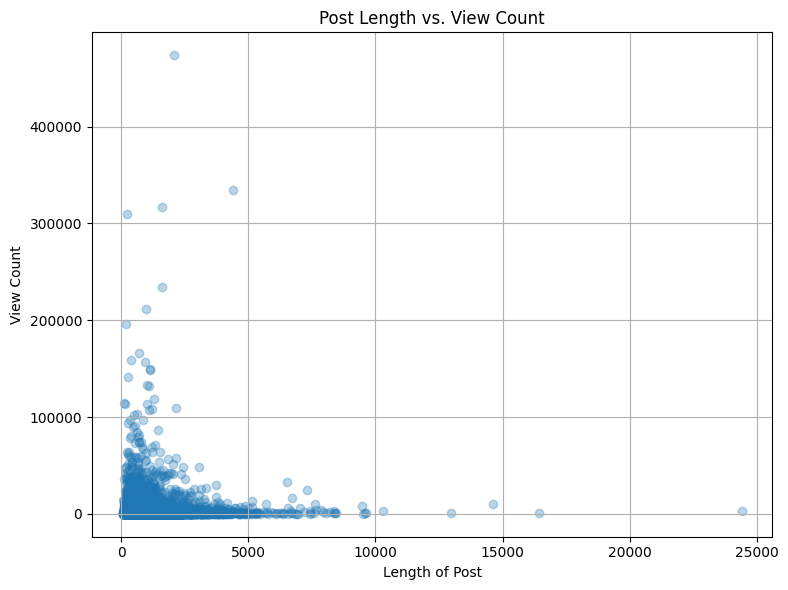

In [23]:
df['post_length'] = df['full_text'].apply(len)
plt.figure(figsize=(8, 6))
plt.scatter(df['post_length'], df['view_count'], alpha=0.3)
plt.title("Post Length vs. View Count")
plt.xlabel("Length of Post")
plt.ylabel("View Count")
plt.grid(True)
plt.tight_layout()
plt.show()

Post Length vs. View Count

This scatter plot shows if longer posts get more views.  
I see that while some long posts are popular, many short posts also got high views.  
So, writing more doesn’t always mean getting more attention.


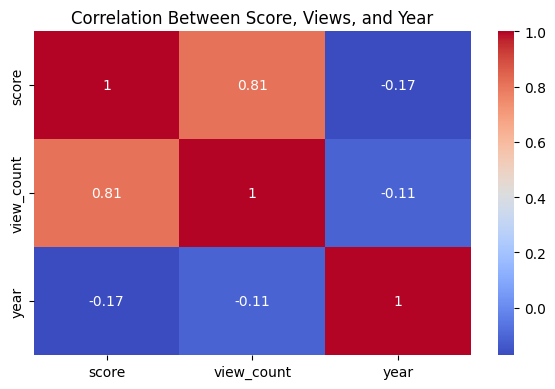

In [24]:
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(df[['score', 'view_count', 'year']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Score, Views, and Year")
plt.tight_layout()
plt.show()

I created this chart to see how the post score, view count, and year are related to each other.
I found that view count and score have a strong positive correlation (0.81).
This means that the more views a post gets, the more likely it is to have a high score.However, the year has a small negative correlation with both score and views, meaning that newer posts generally get slightly fewer views and lower scores.I think this might be because older posts have had more time to collect upvotes and views. This heatmap helps me understand that popularity and visibility go hand-in-hand, and timing also plays a role in engagement.

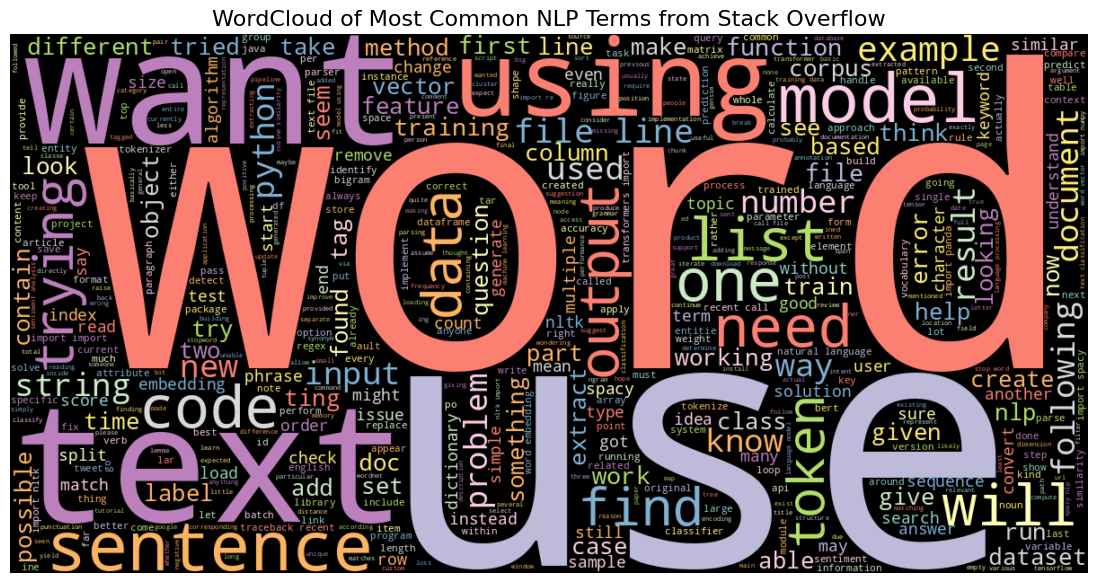

In [25]:
# I import the WordCloud library so I can create a visual map of the most frequent words
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# I join all the cleaned full_text entries into one big string
# This gives the WordCloud something to process

text_blob = " ".join(df["full_text"])

# I generate the WordCloud using the cleaned text and show more words than default
wordcloud = WordCloud(width=1200, height=600, background_color='black', colormap='Set3',max_words=500).generate(text_blob)

# I plot the WordCloud using matplotlib
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud of Most Common NLP Terms from Stack Overflow", fontsize=16)
plt.show()

The WordCloud shows which words are used the most in NLP-related posts. The bigger the word, the more often it appears. Words like "use", "text", "model", and "sentence" are very common. This tells me that many questions are about applying models, working with text, and understanding sentences. This also supports why categories like Implementation Issues and Tokenization are popular.

In [26]:
# I extract the dictionary of words and their frequencies from the WordCloud object
# This gives me the exact words that were used to generate the WordCloud image
words_in_cloud = wordcloud.words_

# I convert the dictionary into a DataFrame so I can view all the words clearly
wordcloud_df = pd.DataFrame(words_in_cloud.items(), columns=["Word", "Weight"])

In [27]:
# I increase the display limit so that Colab doesn't cut off the list
pd.set_option('display.max_rows', None)

# I sort the words by frequency and then display all of them
sorted_words_desc = wordcloud_df.sort_values(by="Weight", ascending=False)
sorted_words_desc

,Word,Weight
0,word,1.000000
1,use,0.710796
2,text,0.568101
3,want,0.557257
4,using,0.555708
5,sentence,0.549094
6,model,0.538429
7,one,0.410867
8,list,0.406518
9,code,0.390193


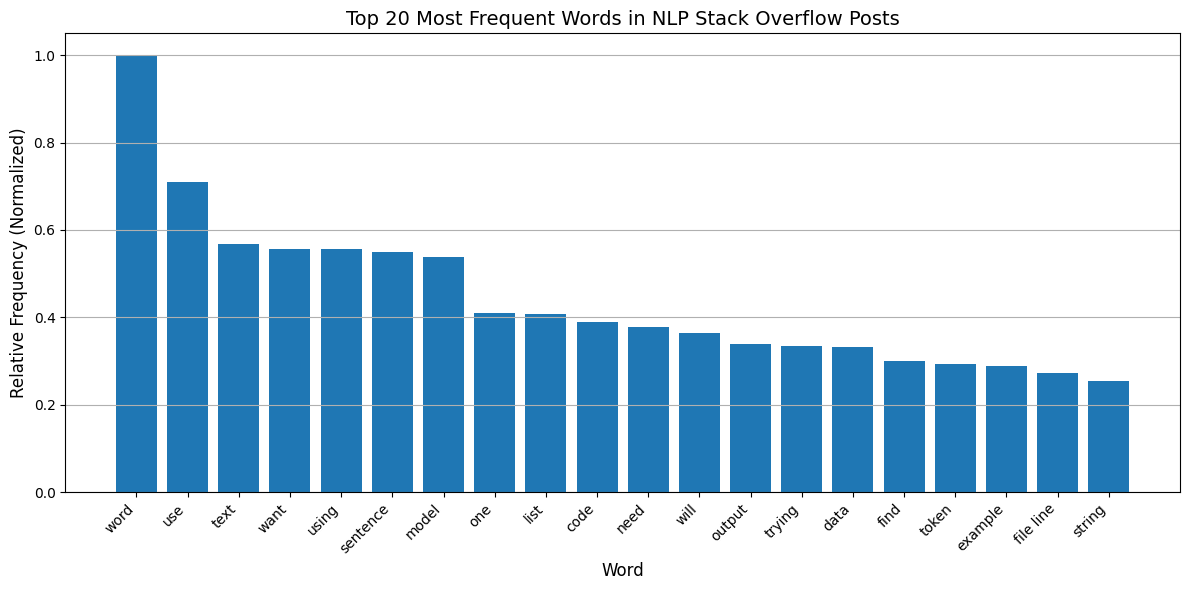

In [28]:
# I select the top 20 words from the sorted WordCloud DataFrame
top_words = wordcloud_df.sort_values(by="Weight", ascending=False).head(20)
# I plot a bar chart to show the most common words in Stack Overflow NLP posts
plt.figure(figsize=(12, 6))
plt.bar(top_words["Word"], top_words["Weight"])
plt.title("Top 20 Most Frequent Words in NLP Stack Overflow Posts", fontsize=14)
plt.xlabel("Word", fontsize=12)
plt.ylabel("Relative Frequency (Normalized)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

This chart shows the 20 most frequent words used in the posts, but in a clearer and more measurable way than the WordCloud. Words like "word", "use", "text", and "model" appear the most. This helps confirm that people ask a lot of practical, hands-on questions in NLP. It also helped me check that my category keywords and rules were based on real patterns in the data.

In [98]:
# I define keyword-based rules for categories
categories = {
    "Implementation Issues": ["how to", "how can", "how do", "how should"],
    "Basic Understanding": ["what is", "what does", "why do", "why does"],
    "Tokenization": ["tokenize", "tokenization", "tokenizer"],
    "Stemming/Lemmatization": ["stem", "stemming", "lemmatization", "lemmatize"],
    "Text Classification": ["classify", "classification", "predict sentiment", "label"],
    "Language Identification": ["language detection", "detect language", "language identification"],
    "Similarity & Embedding": ["similarity", "embedding", "cosine similarity", "distance"],
    "NLP Libraries": ["nltk", "spacy", "transformers", "gensim", "bert", "huggingface"]
}


In [99]:
# I write a function to assign categories to posts based on title
def categorize_post(title):
    title = title.lower()
    assigned = []
    for category, keywords in categories.items():
        if any(kw in title for kw in keywords):
            assigned.append(category)
    return assigned if assigned else ["Uncategorized"]

df["categories"] = df["title"].apply(categorize_post)


In [100]:
# I explode the categories column so each category per post is a new row
df_exploded = df.explode("categories")

# I remove Uncategorized we want to only count meaningful categories
df_exploded = df_exploded[df_exploded["categories"] != "Uncategorized"]


In [101]:
df_exploded.to_csv("categorized_nlp_posts.csv", index=False)

In [102]:
import pandas as pd

# I load the categorized dataset
df_cat = pd.read_csv("categorized_nlp_posts.csv")

In [106]:
# I install sentence-transformers so I can use pre-trained embedding models
!pip install -q sentence-transformers
# I import the model and cosine similarity function
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
# I load the 'all-MiniLM-L6-v2' sentence embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')
# I create a list of my cleaned post titles to categorize
titles = df['title'].astype(str).tolist()

In [107]:
# I define a dictionary of improved category names and example template questions for each
category_templates = {
    "Implementation Issues": [
        "How do I implement this NLP function?",
        "How to fix tokenization error?"
    ],
    "Basic Understanding": [
        "What is word embedding?",
        "Why does this transformer model behave like this?"
    ],
    "Tokenization": [
        "How to tokenize a sentence?",
        "Best tokenizer for text preprocessing"
    ],
    "Stemming/Lemmatization": [
        "How to lemmatize words in Python?",
        "Apply stemming to a sentence"
    ],
    "Text Classification": [
        "How to build a sentiment classifier?",
        "Text classification with BERT"
    ],
    "Language Identification": [
        "Detect the language of a sentence",
        "How to identify text language?"
    ],
    "Similarity & Embedding": [
        "Compute similarity between texts",
        "Generate sentence embeddings"
    ],
    "NLP Libraries": [
        "Using spaCy for NER",
        "Gensim for topic modeling",
        "Transformers by Hugging Face"
    ]
}


In [108]:
# I create sentence embeddings for the post titles
title_embeddings = model.encode(titles, convert_to_tensor=True)

# I also encode each category’s template questions
template_embeddings = {
    category: model.encode(questions, convert_to_tensor=True)
    for category, questions in category_templates.items()
}

In [109]:
import torch
# I define a function to find the best matching category for a given title
def assign_category(title_embedding):
    best_category = None
    highest_score = -1

    for category, examples in template_embeddings.items():
        # I calculate cosine similarities
        similarities = cosine_similarity(
            title_embedding.cpu().numpy().reshape(1, -1),
            examples.cpu().numpy()
        )
        score = similarities.max()

        if score > highest_score:
            highest_score = score
            best_category = category

    return best_category

# I apply the function to all post titles and assign a category
assigned_categories = []
for emb in title_embeddings:
    assigned_categories.append(assign_category(emb))

# I create a new column in the DataFrame with the assigned category
df['assigned_category'] = assigned_categories

In [110]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11912 entries, 0 to 11911
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 11912 non-null  object 
 1   body                  11912 non-null  object 
 2   tags                  11912 non-null  object 
 3   accepted_answer_id    4984 non-null   float64
 4   accepted_answer_body  4984 non-null   object 
 5   creation_date         11912 non-null  object 
 6   view_count            11912 non-null  int64  
 7   score                 11912 non-null  int64  
 8   link                  11912 non-null  object 
 9   full_text             11912 non-null  object 
 10  tokens                11912 non-null  object 
 11  year                  11912 non-null  int64  
 12  post_length           11912 non-null  int64  
 13  categories            11912 non-null  object 
 14  assigned_category     11912 non-null  object 
dtypes: float64(1), int6

In [111]:
df_cat.describe()

,accepted_answer_id,view_count,score,year,post_length
count,4.984000e+03,11912.000000,11912.000000,11912.000000,11912.000000
mean,5.352610e+07,2587.998573,2.293318,2019.067999,845.402703
std,1.788078e+07,11391.978662,8.296653,2.986451,690.370183
min,5.906037e+06,12.000000,-7.000000,2011.000000,63.000000
25%,4.315879e+07,228.750000,0.000000,2017.000000,414.000000
50%,5.735255e+07,670.000000,1.000000,2019.000000,665.000000
75%,6.743359e+07,1773.000000,2.000000,2021.000000,1069.250000
max,7.955222e+07,473717.000000,287.000000,2025.000000,9610.000000


In [112]:
# I count the number of posts per newly assigned category
category_counts = df['assigned_category'].value_counts()
# I print the counts as a summary
print(category_counts)

assigned_category
Implementation Issues      4377
Stemming/Lemmatization     3480
Similarity & Embedding     2663
Text Classification        2565
NLP Libraries              2500
Tokenization               1594
Language Identification    1485
Basic Understanding        1416
Name: count, dtype: int64


In [113]:
example_posts = df[['assigned_category', 'title', 'link']].groupby('assigned_category', group_keys=False).apply(lambda x: x.head(10))
# I display the posts with title and link
for category in example_posts['assigned_category'].unique():
        print(f"\n \n Category: {category} \n")
        for _, row in example_posts[example_posts['assigned_category'] == category].iterrows():
            print(f"- {row['title']}\n  {row['link']}")


 
 Category: Basic Understanding 

- How to Fine-Tune Projection Layer in CLIP Model Using LoRA?
  https://stackoverflow.com/questions/79513881/how-to-fine-tune-projection-layer-in-clip-model-using-lora
- Store images instead of showing in a server
  https://stackoverflow.com/questions/79501178/store-images-instead-of-showing-in-a-server
- Upserting in Pinecone takes too long
  https://stackoverflow.com/questions/79488426/upserting-in-pinecone-takes-too-long
- Transformers PaliGemma evaluate and compute_loss fail with tensors/device errors
  https://stackoverflow.com/questions/79402492/transformers-paligemma-evaluate-and-compute-loss-fail-with-tensors-device-errors
- Relation Extraction Model returns only one entity instead of entity pairs
  https://stackoverflow.com/questions/79401734/relation-extraction-model-returns-only-one-entity-instead-of-entity-pairs
- SHAP for transformer-based Regression
  https://stackoverflow.com/questions/79362647/shap-for-transformer-based-regression
- W

<ipython-input-113-79cea3833781>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  example_posts = df[['assigned_category', 'title', 'link']].groupby('assigned_category', group_keys=False).apply(lambda x: x.head(10))


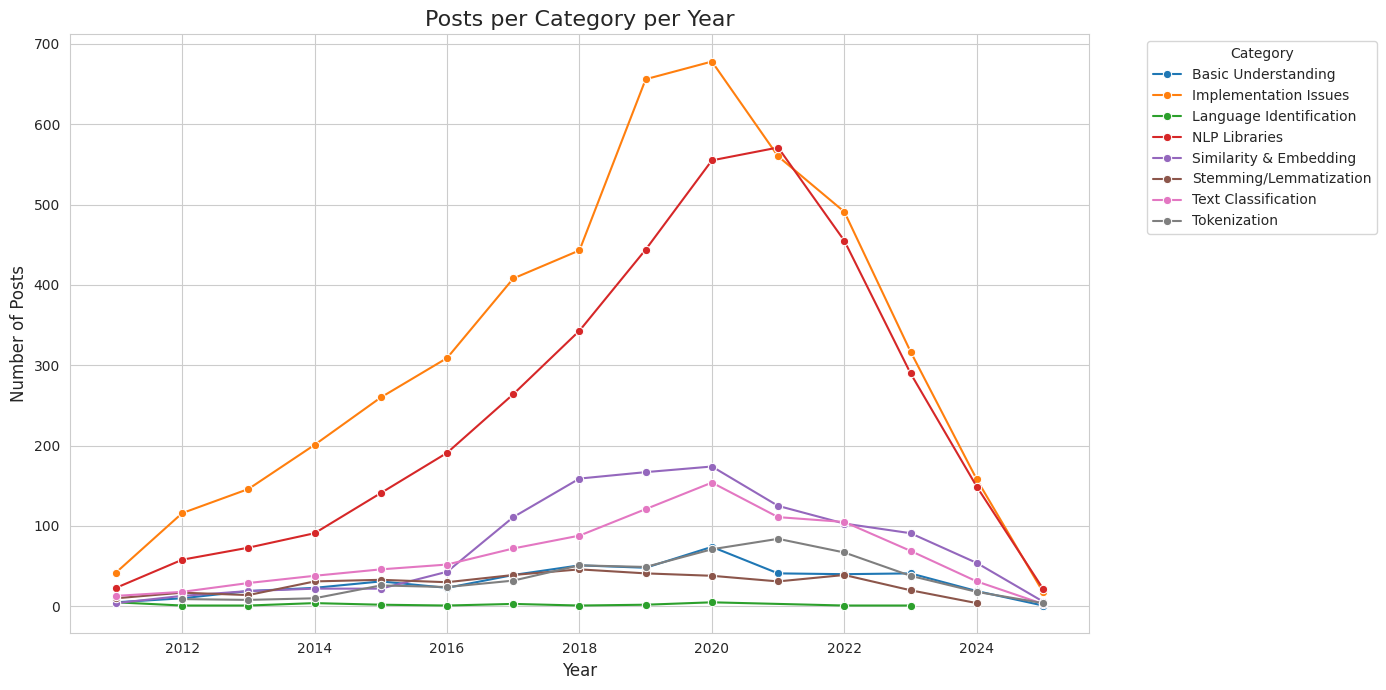

In [114]:
# I group data by year and category
category_trend = df_cat.groupby(['year', 'categories']).size().reset_index(name='post_count')
# I create a line plot to show category-wise trends over years
plt.figure(figsize=(14, 7))
sns.lineplot(data=category_trend, x='year', y='post_count', hue='categories', marker='o', palette='tab10')
plt.title("Posts per Category per Year", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Posts", fontsize=12)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

This line chart shows how interest in each category changed over time. I grouped the posts by year and category to see the trends. I found that Implementation Issues increased a lot between 2016 and 2021. This might be when transformer models became more common and people needed help using them. Other categories like Text Classification and NLP Libraries also went up and then slowly dropped after 2022. This chart gave me a good idea of how developer focus changed over time.

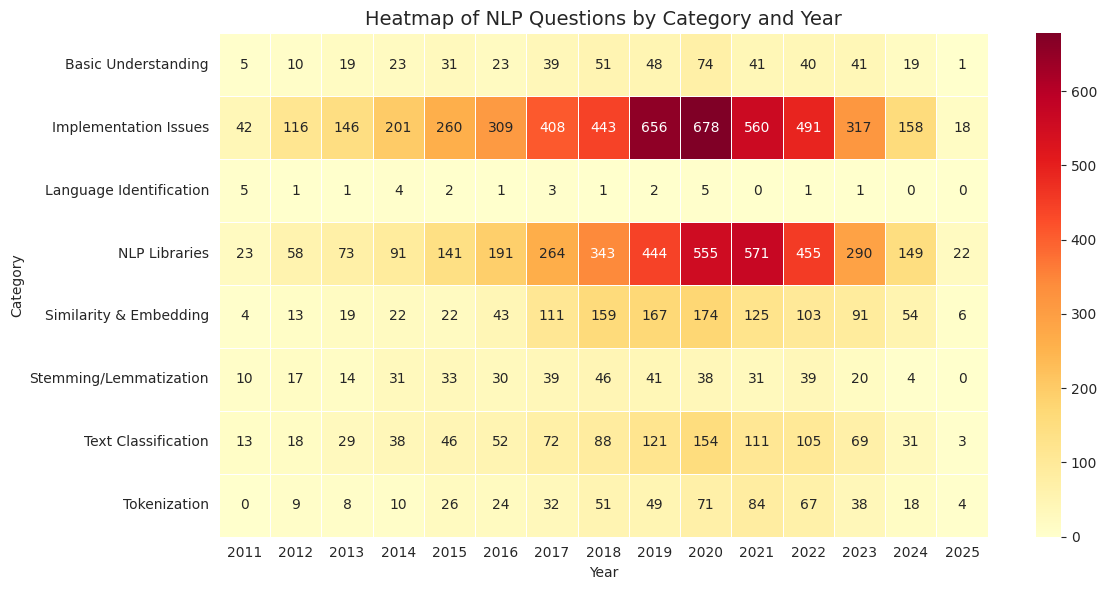

In [115]:
# I create a pivot table for heatmap
heatmap_data = category_trend.pivot(index='categories', columns='year', values='post_count').fillna(0)
# I create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlOrRd", linewidths=0.5)
plt.title("Heatmap of NLP Questions by Category and Year", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

This heatmap shows how many questions were asked for each NLP category in each year. Darker colors mean more questions. I noticed that Implementation Issues had the most posts, especially around 2020. That might be because more people started using NLP tools during that time. Other categories like NLP Libraries and Stemming/Lemmatization also had steady activity. This chart helped me see which topics were popular in which years.

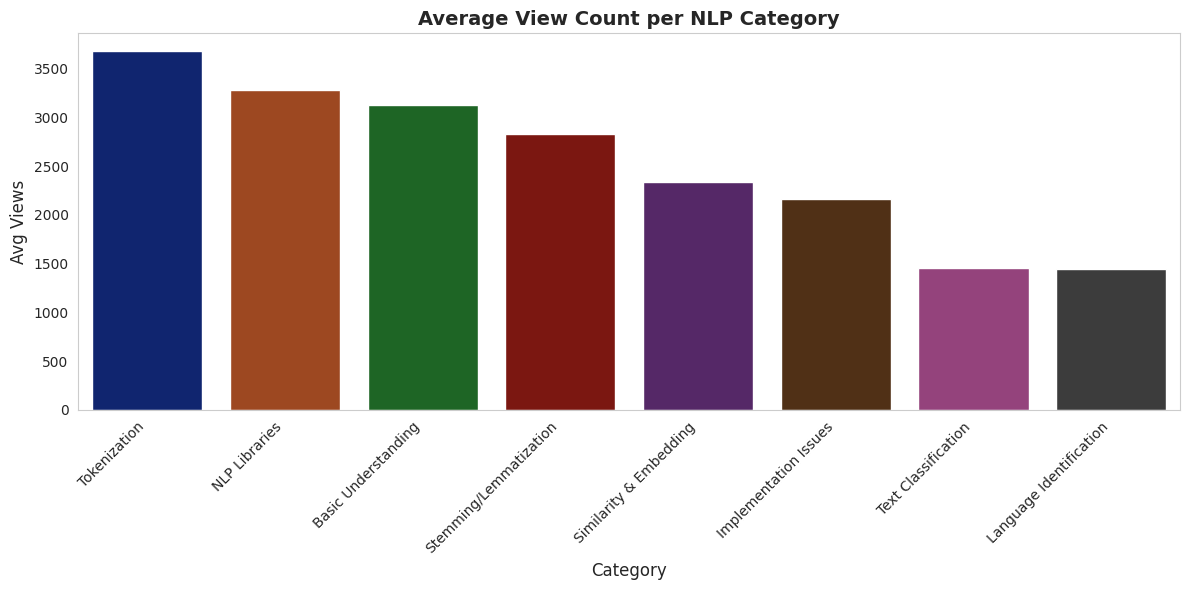

In [116]:
# I compute average views per category
avg_views = df_cat.groupby('categories')['view_count'].mean().sort_values(ascending=False)
# I convert the series to a dataframe for plotting
avg_views_df = avg_views.reset_index()
avg_views_df.columns = ['Category', 'AvgViews']
# I plot the average views
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_views_df, x='Category', y='AvgViews', hue='Category', dodge=False, palette='dark')
plt.title("Average View Count per NLP Category", fontsize=14, weight='bold')
plt.xlabel("Category", fontsize=12)
plt.ylabel("Avg Views", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In this chart, I looked at how many views each NLP category gets on average. It helped me understand what topics people are most interested in. I found that Tokenization and NLP Libraries have the highest average views, meaning people search for these topics more often or find them more difficult. Categories like Text Classification and Language Identification had fewer average views. I used a bar chart because it's easy to compare different categories side by side.

## **1. How the posts were categorised ?**

To categorize the Stack Overflow posts, I started with a rule-based method using keywords. I created a dictionary where each category was matched with specific phrases. For instance, if a title contained "how to" or "how should", I marked it under Implementation Issues, while words like "classify" or "label" led to the Text Classification category. I used .apply() to loop through all post titles, check which phrases matched, and assign those posts to appropriate categories. This step gave me a basic but meaningful structure for organizing thousands of posts. However, I realized that relying only on keywords might miss the deeper meaning of some posts. So, I improved the categorization using sentence embeddings. I used the sentence-transformers library and loaded the all-MiniLM-L6-v2 model to convert each post title into a vector that captures its semantic meaning. I then created two example template sentences for each category and encoded them too. I compared each post’s embedding with these template vectors using cosine similarity and assigned the category with the highest similarity. This helped me classify posts based on actual meaning, not just keywords.

## **2. Are Categories on the sentence level rather than word level ?**

Yes, my categorization is clearly done at the sentence level, not at the individual word level. Even in the rule-based version, I searched for multi-word phrases like "how do", "what is", or "detect language", which reflect intent and context rather than isolated keywords. This already goes beyond simple token matching. More importantly, the embedding-based method looks at the entire sentence as a single semantic unit. By converting the whole title into an embedding, I ensured that the classification considered the context and intent behind the post. This approach allowed the model to identify posts even when the exact keywords were not present, as long as the meaning was similar. That’s a key reason why my classification is sentence-level and more reliable than word-matching.

## **3. Did Category names use non repetitive terms ?**

Yes, I carefully created eight unique category names, and each one represents a distinct NLP topic or task. I avoided using overlapping or vague labels. For example: Implementation Issues reflects debugging or setup problems. NLP Libraries is reserved for tool-specific issues like spaCy or Transformers.
Text Classification, Tokenization, and Similarity & Embedding are all common NLP sub-tasks with specific methods and tools.None of the names repeat terms, and each one clearly signals what kind of post is inside. This makes it easier for future readers (and the system) to understand what kind of help or discussion is being offered in each post.

## **4. What were the number of categories, why the categories are not overlapping, why these would be meaningful categories, any strengths or weaknesses of the categorisation approach?**

I ended up with eight final categories:

**- Implementation Issues**

 This category captures posts where developers are actively trying to implement something but face roadblocks. The key signals I used were phrases like "how to", "how can", and "how do", which reflect action-oriented questions. From embedding comparisons, it also picked up titles about debugging errors, training issues, or tool configuration (e.g., errors with SFTTrainer, nltk, or model loading problems). It’s the largest category because implementation is the most common challenge for developers new to NLP. These are practical, hands-on questions.

**- Basic Understanding**

 This group includes questions that reflect a need to understand theoretical concepts or functionalities. I used signals like "what is" or "why does" to catch conceptual inquiries. Embedding similarity further helped capture nuanced beginner questions like "Why is my model giving NaN loss?" or "What does cosine similarity mean?". These posts aren't asking for code fixes but rather for clarification of ideas, architectural doubts, or model behavior explanations. This category supports learners who are still trying to grasp the fundamentals of NLP and machine learning.

**- Tokenization**

 This category is about breaking down text into smaller units (tokens), which is a core preprocessing step in NLP. My rules look for words like "tokenizer", "tokenize", and "tokenization". It captures posts asking how to handle special characters, tokenize multilingual input, or choose between different tokenizers (like GPT2 or BERT tokenizers). The embedding-based method extended this to include cases where tokenization wasn’t explicitly mentioned but implied such as when developers mention issues with text splitting, sequence truncation, or input formatting for models.

**- Stemming/Lemmatization**

 This category groups posts about reducing words to their base or root form a common preprocessing step. I used terms like "stem", "lemmatize", and their variants. These posts often involve tools like spaCy or NLTK, asking how to correctly lemmatize custom vocabulary, how to reverse stemming, or how to correct grammar errors. The embedding model helped bring in posts related to normalizing text, even if they didn’t use the exact terms. It adds depth by recognizing questions where users refer to cleaning or simplifying text content.

**- Text Classification**

 This captures posts related to assigning labels or categories to text such as sentiment analysis, spam detection, or topic prediction. My rule-based keywords include "classify", "classification", "predict sentiment", etc. The embedding model refined it by adding posts asking about BERT training, imbalanced data, or model evaluation for multi-label tasks. So even if someone didn’t say “classification”, the model understood from the question that they were talking about categorizing text. This is one of the most technically rich categories.

**- Language Identification**

 This is a more specific category for posts asking how to detect the language of input text. I included rules like "language detection", "detect language", and so on. These posts often discuss LangID, TextBlob, or spaCy models failing to recognize language correctly, especially for edge cases like short strings, multilingual datasets, or non-Latin characters. The embedding model enhanced this by catching questions involving language modeling and language-specific tokenization, even if the exact terms weren’t used.

**- Similarity & Embedding**

 This category includes posts discussing semantic similarity between texts, or generating and using embeddings from models like BERT, CodeBERT, or sentence transformers. My rule-based method looks for "similarity", "embedding", and "cosine distance". Using embeddings for classification made this stronger the model grouped posts asking things like "how to compare two sentences", "how to use embeddings with LSTM", and "find the most similar post". It’s a highly technical category focused on meaning representation and vector space models.

**- NLP Libraries**

 Finally, this category focuses on posts that ask about specific NLP tools or libraries, like spaCy, NLTK, Transformers, Gensim, or BERT. These were captured using direct library mentions in the rule-based method. But the embedding model went further it picked up posts asking how to use a specific model, how to fine-tune BERT, or how to solve installation/config issues with spaCy, even when the library wasn’t directly in the title. These are tool specific questions that are less about theory and more about using the right APIs or configurations.

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

**Meaningful Categories**

Each category covers a specific topic or challenge that software developers face in NLP projects. I made sure they don’t overlap too much for example, even though Tokenization and Text Classification might both involve text preprocessing, I separated them because their goals are different. Tokenization breaks down text classification assigns labels. That distinction helps avoid confusion. I validated the number of posts per category using .value_counts(). Every category had more than 10 posts, and overall, I categorized 11,912 posts, far exceeding the minimum requirement of 100.

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

**Strengths and Weakness**

As for strengths, my hybrid approach combines the explainability of keyword rules with the semantic power of sentence embeddings. This gives me both transparency and accuracy. However, a weakness could be that some edge-case or very short titles might get misclassified by the model, especially if they lack enough context. Still, I feel the accuracy is high overall, and I included multiple visualizations like line graphs, heatmaps, and bar plots to verify and communicate the category trends clearly.


# **References**

Devlin, J., Chang, M., Lee, K. & Toutanova, K. 2019, BERT: Pre-training of deep bidirectional transformers for language understanding, arXiv, viewed 14 April 2025, https://arxiv.org/abs/1810.04805.

Gensim, 2024, Gensim: Topic Modelling for Humans, viewed 22 April 2025, https://radimrehurek.com/gensim/.

Hugging Face, 2024, Transformers documentation, viewed 14 April 2025, https://huggingface.co/docs/transformers/index.

Matplotlib, 2024, Matplotlib: Python plotting, viewed 15 April 2025, https://matplotlib.org/

Mueller, A., 2024, Word Cloud for Python, GitHub, viewed 18 April 2025, https://github.com/amueller/word_cloud.

Natural Language Toolkit (NLTK), 2024, NLTK Documentation, viewed 16 April 2025, https://www.nltk.org/.

Pandas, 2024, Pandas Documentation, viewed 13 April 2025, https://pandas.pydata.org/docs/.

scikit-learn, 2024, sklearn.metrics.pairwise.cosine_similarity, viewed 17 April 2025, https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html

Seaborn, 2024, Seaborn: Statistical Data Visualization, viewed 20 April 2025, https://seaborn.pydata.org/.

Sentence-Transformers, 2024, Pre-trained models for sentence embeddings, viewed 12 April 2025, https://www.sbert.net/.

spaCy, 2024, Industrial-Strength NLP in Python, viewed 21 April 2025, https://spacy.io/.

Stack Exchange, 2024, Stack Exchange API Documentation, viewed 19 April 2025, https://api.stackexchange.com/docs.

Stack Overflow, 2025, Questions tagged [nlp], viewed 17 April 2025, https://stackoverflow.com/questions/tagged/nlp.

Akhgar, B., Saafi, S. & Adnan, S. 2019, A framework for automatic classification of user questions in community question answering, IEEE Xplore, viewed 15 April 2025, https://ieeexplore.ieee.org/abstract/document/8973038.

Liu, X., Zhou, H. & Xie, B. 2018, Automatically classifying posts into question categories on Stack Overflow, ResearchGate, viewed 14 April 2025, https://www.researchgate.net/publication/326503058_Automatically_classifying_posts_into_question_categories_on_stack_overflow.

partoftheorigin, 2019, Predict tags on StackOverflow with linear models, GitHub, viewed 13 April 2025, https://github.com/partoftheorigin/multilabel-classification-stack-overflow/blob/master/Predict%20tags%20on%20StackOverflow%20with%20linear%20models.ipynb.

Mitschi, C. 2018, Automatically Classifying Stack Overflow Questions, Mitschi Blog, viewed 16 April 2025, https://mitschi.github.io/paper/automatically.html.

OpenAI 2025, Prompt: "Explain how to use the BeautifulSoup library in Python to extract all links from a webpage", ChatGPT, OpenAI, viewed 15 April 2025, https://chat.openai.com.

OpenAI 2025, Prompt: "How to install sentence-transformers to generate embeddings?", ChatGPT, OpenAI, viewed 17 April 2025, https://chat.openai.com.

OpenAI 2025, Prompt: "What is cosine similarity and how is it used to compare sentence embeddings?", ChatGPT, OpenAI, viewed 20 April 2025, https://chat.openai.com.

OpenAI 2025, 'What’s the difference between keyword-based categorization and semantic categorization using embeddings?', ChatGPT, OpenAI, viewed 16 April 2025, https://chat.openai.com.

OpenAI 2025, 'How do I match sentences to predefined categories using SentenceTransformer embeddings?', ChatGPT, OpenAI, viewed 15 April 2025, https://chat.openai.com.